# Try OpenEO API

In [83]:
import openeo

In [84]:
connection = openeo.connect("openeo.dataspace.copernicus.eu")

In [85]:
connection

<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with NullAuth>

In [86]:
connection.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.2/' with OidcBearerAuth>

bbox of Altstadt, Dresden, Germany
- [13.6864402, 51.0280799, 13.7872926, 51.0766681] (minx, miny, maxx, maxy)

bbox of Dresden, Germany
- [13.5793237, 50.974937 , 13.9660626, 51.1777202] 

In [93]:
sentinel2_cube = connection.load_collection(
    "SENTINEL2_L2A",
    spatial_extent={"west": 13.5793237, "south": 50.974937, "east": 13.9660626, "north":  51.1777202},
    temporal_extent=["2024-05-01", "2024-08-31"],
    max_cloud_cover=5,
    bands=["B02", "B03", "B04", "B08", "B11"]
)

In [94]:
sentinel2_cube.print_json()

{
  "process_graph": {
    "loadcollection1": {
      "process_id": "load_collection",
      "arguments": {
        "bands": [
          "B02",
          "B03",
          "B04",
          "B08",
          "B11"
        ],
        "id": "SENTINEL2_L2A",
        "properties": {
          "eo:cloud_cover": {
            "process_graph": {
              "lte1": {
                "process_id": "lte",
                "arguments": {
                  "x": {
                    "from_parameter": "value"
                  },
                  "y": 5
                },
                "result": true
              }
            }
          }
        },
        "spatial_extent": {
          "west": 13.5793237,
          "south": 50.974937,
          "east": 13.9660626,
          "north": 51.1777202
        },
        "temporal_extent": [
          "2024-05-01",
          "2024-08-31"
        ]
      },
      "result": true
    }
  }
}


In [95]:
sentinel2_cube_latest = sentinel2_cube.max_time()

In [96]:
sentinel2_cube_latest.to_json()

'{\n  "process_graph": {\n    "loadcollection1": {\n      "process_id": "load_collection",\n      "arguments": {\n        "bands": [\n          "B02",\n          "B03",\n          "B04",\n          "B08",\n          "B11"\n        ],\n        "id": "SENTINEL2_L2A",\n        "properties": {\n          "eo:cloud_cover": {\n            "process_graph": {\n              "lte1": {\n                "process_id": "lte",\n                "arguments": {\n                  "x": {\n                    "from_parameter": "value"\n                  },\n                  "y": 5\n                },\n                "result": true\n              }\n            }\n          }\n        },\n        "spatial_extent": {\n          "west": 13.5793237,\n          "south": 50.974937,\n          "east": 13.9660626,\n          "north": 51.1777202\n        },\n        "temporal_extent": [\n          "2024-05-01",\n          "2024-08-31"\n        ]\n      }\n    },\n    "reducedimension1": {\n      "process_id": "

In [97]:
sentinel2_cube_med = sentinel2_cube.reduce_dimension(dimension='t', reducer='median')

In [98]:
# sentinel2_cube_latest.download("../data/raw/sentinel-2/sentinel2_openeo.geotiff", format="GTiff")
sentinel2_cube_latest.download("../data/raw/sentinel-2/sentinel2_openeo_dresden.geotiff", format="GTiff")

In [99]:
# sentinel2_cube_med.download("../data/raw/sentinel-2/sentinel2_openeo_med_3months.geotiff", format="GTiff")
# sentinel2_cube_med.download("../data/raw/sentinel-2/sentinel2_openeo_med_3months_dresden.geotiff", format="GTiff")
sentinel2_cube_med.download("../data/raw/sentinel-2/sentinel2_openeo_med_4months_dresden.geotiff", format="GTiff")

# Try with STAC

In [75]:
from pystac_client import Client

ModuleNotFoundError: No module named 'pystac_client'

In [59]:
api_url = "https://earth-search.aws.element84.com/v1"

In [60]:
client = Client.open(api_url)

In [61]:
collections = client.get_collections()

In [62]:
for collection in collections:
    print(collection)

<CollectionClient id=sentinel-2-pre-c1-l2a>
<CollectionClient id=cop-dem-glo-30>
<CollectionClient id=naip>
<CollectionClient id=cop-dem-glo-90>
<CollectionClient id=landsat-c2-l2>
<CollectionClient id=sentinel-2-l2a>
<CollectionClient id=sentinel-2-l1c>
<CollectionClient id=sentinel-2-c1-l2a>
<CollectionClient id=sentinel-1-grd>


In [63]:
s2_search = client.search(
    collections=["sentinel-2-l2a"],
    bbox=[13.6864402, 51.0280799, 13.7872926, 51.0766681],
    query=["eo:cloud_cover<10"],
    sortby=["-properties.eo:cloud_cover"],
    datetime="2024-05-01/2024-08-31"
)

In [64]:
s2_items = s2_search.item_collection()
for item in s2_items:
    print(item.properties["eo:cloud_cover"])

7.069943
4.35647
4.08761
3.84155
2.503777
1.05776
0.027982
0.019542
0.004531


In [65]:
selected_item = s2_items[7]

In [66]:
assets = selected_item.assets
print(assets.keys())

dict_keys(['aot', 'blue', 'coastal', 'granule_metadata', 'green', 'nir', 'nir08', 'nir09', 'red', 'rededge1', 'rededge2', 'rededge3', 'scl', 'swir16', 'swir22', 'thumbnail', 'tileinfo_metadata', 'visual', 'wvp', 'aot-jp2', 'blue-jp2', 'coastal-jp2', 'green-jp2', 'nir-jp2', 'nir08-jp2', 'nir09-jp2', 'red-jp2', 'rededge1-jp2', 'rededge2-jp2', 'rededge3-jp2', 'scl-jp2', 'swir16-jp2', 'swir22-jp2', 'visual-jp2', 'wvp-jp2'])


In [67]:
for key, asset in assets.items():
    print(f"{key}:{asset.title}")

aot:Aerosol optical thickness (AOT)
blue:Blue (band 2) - 10m
coastal:Coastal aerosol (band 1) - 60m
granule_metadata:None
green:Green (band 3) - 10m
nir:NIR 1 (band 8) - 10m
nir08:NIR 2 (band 8A) - 20m
nir09:NIR 3 (band 9) - 60m
red:Red (band 4) - 10m
rededge1:Red edge 1 (band 5) - 20m
rededge2:Red edge 2 (band 6) - 20m
rededge3:Red edge 3 (band 7) - 20m
scl:Scene classification map (SCL)
swir16:SWIR 1 (band 11) - 20m
swir22:SWIR 2 (band 12) - 20m
thumbnail:Thumbnail image
tileinfo_metadata:None
visual:True color image
wvp:Water vapour (WVP)
aot-jp2:Aerosol optical thickness (AOT)
blue-jp2:Blue (band 2) - 10m
coastal-jp2:Coastal aerosol (band 1) - 60m
green-jp2:Green (band 3) - 10m
nir-jp2:NIR 1 (band 8) - 10m
nir08-jp2:NIR 2 (band 8A) - 20m
nir09-jp2:NIR 3 (band 9) - 60m
red-jp2:Red (band 4) - 10m
rededge1-jp2:Red edge 1 (band 5) - 20m
rededge2-jp2:Red edge 2 (band 6) - 20m
rededge3-jp2:Red edge 3 (band 7) - 20m
scl-jp2:Scene classification map (SCL)
swir16-jp2:SWIR 1 (band 11) - 20m


In [68]:
print(assets["thumbnail"].href)

https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/33/U/US/2024/5/S2B_33UUS_20240515_1_L2A/thumbnail.jpg


In [69]:
import rioxarray
import matplotlib.pyplot as plt

In [70]:
nir_href = assets["nir"].href
nir = rioxarray.open_rasterio(nir_href)
nir

<xarray.DataArray (band: 1, y: 10980, x: 10980)> Size: 241MB
[120560400 values with dtype=uint16]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 88kB 3e+05 3e+05 3e+05 ... 4.098e+05 4.098e+05
  * y            (y) float64 88kB 5.7e+06 5.7e+06 5.7e+06 ... 5.59e+06 5.59e+06
    spatial_ref  int64 8B 0
Attributes:
    OVR_RESAMPLING_ALG:  AVERAGE
    AREA_OR_POINT:       Area
    _FillValue:          0
    scale_factor:        1.0
    add_offset:          0.0

In [71]:
nir.rio.crs

CRS.from_wkt('PROJCS["WGS 84 / UTM zone 33N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",15],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32633"]]')

In [72]:
nir_reprojected = nir.rio.reproject("EPSG:4326")
print(nir_reprojected.rio.crs)

EPSG:4326


In [73]:
city_bbox = [13.6864402, 51.0280799, 13.7872926, 51.0766681]
raster_clip_box = nir_reprojected.rio.clip_box(*city_bbox)
print(raster_clip_box.shape)

(1, 405, 356)


22.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)


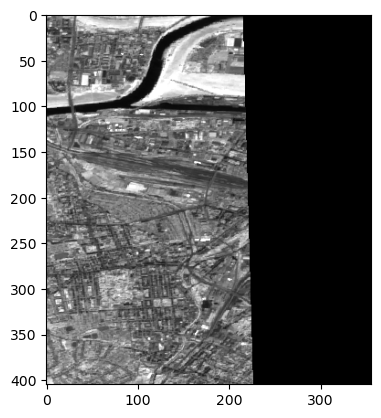

In [74]:
%%timeit -n 5 -r 1
plt.imshow(raster_clip_box[0, :, :], cmap='gray')
plt.clim(vmin=10, vmax=5000)

# Try GEE

In [1]:
import ee

ee.Authenticate()

True

In [2]:
ee.Initialize(project='ee-japanpitchaporn')

In [3]:
bbox = ee.Geometry.BBox(13.6864402, 51.0280799, 13.7872926, 51.0766681)

In [4]:
s2_collection = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
                 .filterDate('2024-05-01', '2024-08-31')
                 .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 5))
                 .filter(ee.Filter.bounds(bbox))
                )

In [5]:
s2_collection.getInfo()

{'type': 'ImageCollection',
 'bands': [],
 'version': 1734515679432845,
 'id': 'COPERNICUS/S2_SR_HARMONIZED',
 'properties': {'date_range': [1490659200000, 1647907200000],
  'period': 0,
  'system:visualization_0_min': '0.0',
  'type_name': 'ImageCollection',
  'keywords': ['copernicus',
   'esa',
   'eu',
   'msi',
   'reflectance',
   'sentinel',
   'sr'],
  'system:visualization_0_bands': 'B4,B3,B2',
  'thumb': 'https://mw1.google.com/ges/dd/images/COPERNICUS_S2_SR_thumb.png',
  'description': '<p>Sentinel-2 is a wide-swath, high-resolution, multi-spectral\nimaging mission supporting Copernicus Land Monitoring studies,\nincluding the monitoring of vegetation, soil and water cover,\nas well as observation of inland waterways and coastal areas.</p><p>The Sentinel-2 L2 data are downloaded from scihub. They were\ncomputed by running sen2cor. WARNING: ESA did not produce L2 data\nfor all L1 assets, and earlier L2 coverage is not global.</p><p>The assets contain\n12 UINT16 spectral bands 

In [6]:
med_s2_img = s2_collection.median().clip(bbox)

In [7]:
import geemap

In [8]:
geemap.ee_initialize()

In [9]:
Map = geemap.Map()

In [10]:
vis = {
    'min': 0.0,
    'max': 3000,
    'bands': ['B4', 'B3', 'B2'],
}

Map.setCenter(13.6864402, 51.0280799, 12)
Map.addLayer(med_s2_img, vis, 'Sentinel-2')
Map.addLayer(bbox, {}, 'Polygon')
Map

Map(center=[51.0280799, 13.6864402], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Se…

In [71]:
# Retrieve the projection information from a band of the original image.
# Call getInfo() on the projection to request a client-side object containing
# the crs and transform information needed for the client-side Export function.
# projection = med_s2_img.select('B2').projection().getInfo()

In [20]:
med_s2_img = med_s2_img.setDefaultProjection('EPSG:32633')

In [21]:
# geemap.download_ee_image(med_s2_img, filename='test.tif', crs='EPSG:32633', region=bbox)
geemap.download_ee_image(med_s2_img, filename='test.tif', crs='EPSG:32633')

Consider adjusting `region`, `scale` and/or `dtype` to reduce the test.tif download size (raw: 8.23 GB).


test.tif: |          | 0.00/8.23G (raw) [  0.0%] in 00:00 (eta:     ?)

# Try earthaccess

In [64]:
import json

from odc.stac import configure_rio, load
from pystac_client import Client as PystacClient
import geopandas as gpd
import numpy as np

from utils import hls_config

In [65]:
# from dask.distributed import Client as DaskClient

# dask_client = DaskClient()
# dask_client

In [66]:
# The catalog URL for the Earthdata STAC containing HLS
catalog = "https://cmr.earthdata.nasa.gov/cloudstac/LPCLOUD/"

# pystac_client is used to connect to the catalog
stac_client = PystacClient.open(catalog)

In [67]:
# Specify both Landsat and Sentinel-2 HLS collections for the query
collections = ["HLSS30.v2.0"]

In [68]:
# Set the start date and end date
start_date = "2024-05-01"
end_date = "2024-08-31"

# Format the date range for the query
date_range = f"{start_date}/{end_date}"

In [69]:
# Search for items in the collection
items = list(
    stac_client.search(
        collections=collections, bbox=[13.6864402, 51.0280799, 13.7872926, 51.0766681], datetime=date_range
    ).items()
)

print(f"Found {len(items)} items")

Found 78 items


In [70]:
import earthaccess

earthaccess.login()

In [71]:
# This code will be wrapped by `get_edl_token` in the next earthaccess release
token = earthaccess.__auth__.token["access_token"]

# Configure rasterio to use cloud defaults, and GDAL to use the authorization token
header_string = f"Authorization: Bearer {token}"
configure_rio(cloud_defaults=True, GDAL_HTTP_HEADERS=header_string)

In [72]:
data = load(
    items,
    resolution=30,
    crs="EPSG:32633",
    chunks={},
    groupby="solar_day",
    # stac_cfg=hls_config,
    bands=["B02", "B03", "B04", "B08", "B11"],
    bbox=[13.6864402, 51.0280799, 13.7872926, 51.0766681]
)

data

<xarray.Dataset> Size: 36MB
Dimensions:      (y: 186, x: 239, time: 41)
Coordinates:
  * y            (y) float64 1kB 5.659e+06 5.659e+06 ... 5.654e+06 5.654e+06
  * x            (x) float64 2kB 4.079e+05 4.079e+05 ... 4.15e+05 4.15e+05
    spatial_ref  int32 4B 32633
  * time         (time) datetime64[ns] 328B 2024-05-02T10:16:37.741000 ... 20...
Data variables:
    B02          (time, y, x) float32 7MB dask.array<chunksize=(1, 186, 239), meta=np.ndarray>
    B03          (time, y, x) float32 7MB dask.array<chunksize=(1, 186, 239), meta=np.ndarray>
    B04          (time, y, x) float32 7MB dask.array<chunksize=(1, 186, 239), meta=np.ndarray>
    B08          (time, y, x) float32 7MB dask.array<chunksize=(1, 186, 239), meta=np.ndarray>
    B11          (time, y, x) float32 7MB dask.array<chunksize=(1, 186, 239), meta=np.ndarray>

In [73]:
from osgeo import gdal
# GDAL configurations used to successfully access LP DAAC Cloud Assets via vsicurl 
gdal.SetConfigOption('GDAL_HTTP_COOKIEFILE','~/cookies.txt')
gdal.SetConfigOption('GDAL_HTTP_COOKIEJAR', '~/cookies.txt')
gdal.SetConfigOption('GDAL_DISABLE_READDIR_ON_OPEN','EMPTY_DIR')
gdal.SetConfigOption('CPL_VSIL_CURL_ALLOWED_EXTENSIONS','TIF')
gdal.SetConfigOption('GDAL_HTTP_UNSAFESSL', 'YES')
gdal.SetConfigOption('GDAL_HTTP_MAX_RETRY', '10')
gdal.SetConfigOption('GDAL_HTTP_RETRY_DELAY', '0.5')

In [ ]:
# # Define a simple plotting function to reuse
# def plot_rgb(data):
#     # Select the red green and blue bands
#     rgb = data[["B04", "B03", "B02"]]
#     print(rgb)
#     # Select a subset of images that show clear and cloudy images
#     rgb_subset = rgb.isel(time=slice(4, 7)).to_array()
#     print(rgb_subset)
    
#     # Display the image
#     rgb_subset.plot.imshow()


# plot_rgb(data)

<xarray.Dataset> Size: 22MB
Dimensions:      (time: 41, y: 186, x: 239)
Coordinates:
  * y            (y) float64 1kB 5.659e+06 5.659e+06 ... 5.654e+06 5.654e+06
  * x            (x) float64 2kB 4.079e+05 4.079e+05 ... 4.15e+05 4.15e+05
    spatial_ref  int32 4B 32633
  * time         (time) datetime64[ns] 328B 2024-05-02T10:16:37.741000 ... 20...
Data variables:
    B04          (time, y, x) float32 7MB dask.array<chunksize=(1, 186, 239), meta=np.ndarray>
    B03          (time, y, x) float32 7MB dask.array<chunksize=(1, 186, 239), meta=np.ndarray>
    B02          (time, y, x) float32 7MB dask.array<chunksize=(1, 186, 239), meta=np.ndarray>
<xarray.DataArray (variable: 3, time: 3, y: 186, x: 239)> Size: 2MB
dask.array<stack, shape=(3, 3, 186, 239), dtype=float32, chunksize=(1, 1, 186, 239), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 1kB 5.659e+06 5.659e+06 ... 5.654e+06 5.654e+06
  * x            (x) float64 2kB 4.079e+05 4.079e+05 ... 4.15e+05 4.15e+05
    sp

ValueError: DataArray must be 2d